# Ingegnerizzazione del traffico

In questo capitolo vado a mostrare gli aspetti di modellazione del sistema, enunciare il problema e gli algoritmi
proposti.

Introduzione Il routing in una rete è un’operazione complessa che coinvolge molti attori e protcolli che permettono
l’organizzazione fra tutti questi componenti indipendenti fra di loro. Le ragioni della complessità sono molteplici:

Il routing richiede un grado di coordinazione fra i vai nodi nella rete o nel segmento di rete considerato piuttosto che
solo fra due nodi. Ad esempio pensiamo i protocolli di livello 2 e livello 4.

L’architettura di routing deve risolvere tutti quei casi di guasti e malfunzionamenti dei collegamenti o dei nodi,
redirezionare il traffico ed aggiornare i database informativi di ogni device.

Per ottenere delle performance buone, l’algoritmo di routing può essere costretto a modificare le sue rotte
precedentemente calcolate quando parti o segmenti di rete diventano congestionati.

Difficoltà e obiettivi nel routing Le due funzioni principali di un algoritmo di routing sono:

```{margin} Routing table
È la struttura dati che un dispositivo ha al suo interno in cui troviamo una lista di destinatari, la distanza e come
raggiungere quel preciso destinatario ed in più altre informazioni a seconda del protocollo finale che la userà
```

È la struttura dati che un dispositivo ha al suo interno in cui troviamo una lista di destinatari, la distanza e come
raggiungere quel preciso destinatario ed in più altre informazioni a seconda del protocollo finale che la userà

la selezione delle rotte fra le varie coppie origine destinazione

la consegna dei messaggi alla corretta destinazione una volta scelta la rotta

La seconda funzione può sembrare banale una volta usate le routing table. Ciò non è sempre vero, in quanto questo
concetto è molto semplice nel caso che io possa fare affidamento sull’infrastruttura di rete. Nel caso in cui questo non
sia vero e quindi io ho a che fare con una infrastruttura non affidabile, diventa fondamentale il modo in cui scelgo il
next-hop.

```{margin} Next-hop
È il dispositivo successivo rispetto al device sotto esame, all’interno del percorso che unisce topologicamente due
punti di interesse, ad esempio possono essere una coppia origine-destinazione
```

In quanto è possibile che 2 scelte diverse di next-hop portino allo stesso destinatario nella topologia, ma un next-hop
è stato disconnesso poiché il collegamento prescelto non è più disponibile. Non mi concentro sulla seconda funzione e
sul capire cosa succede nel caso che un collegamento non sia disponibile ma mi concentrerò sulla prima funzione e come
influisce sulle performance della rete.

Vi sono due metriche principali sulla performance di una rete che sono influenzati dall’algoritmo di routing:

1. Throughput, la quantità di servizio offerta dalla rete

2. Latenza media dei pacchetti, la qualità del servizio offerto dalla rete

Il routing interagisce con il controllo di flusso per determinare queste metriche di performance attraverso un controllo
a catena chiusa.

:::{figure-md} markdown-fig
<img src="https://miro.medium.com/max/1400/1*q_J7uLY97EyiFdYXOXuG0g.png" alt="mcu" class="bg-primary mb-1" width="700px">

Immagine **temporanea**
:::

Una euristica molto efficace nel tentare di mantenere bassa la latenza di percorrenza del sistema all'aumentare del traffico
è la seguente:

> All'aumentare dell'intensità media del carico offerto valuto la latenza media del sistema, quando qusta diventa 
> eccessiva inizio a scartare dei pacchetti

Questo ha come effetto il comportamento secondo cui tanto più l'algoritmo riesce a tenere bassa la latenza e tanto più 
potrà ammettere traffico ed aumentare così il throughput che la rete offre.

Propongo la seguente simulazione:

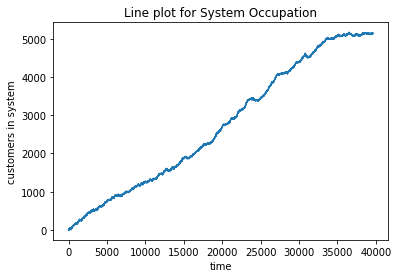

average wait = 274448.294
received: 80145, dropped 332, sent 80145
loss rate: 0.004142491733732609
average system occupancy: 2738.686


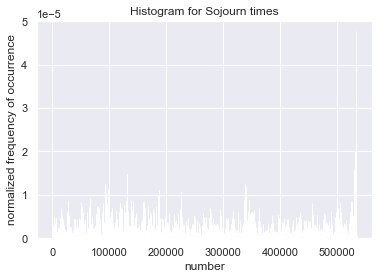

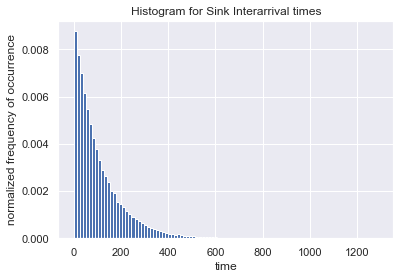

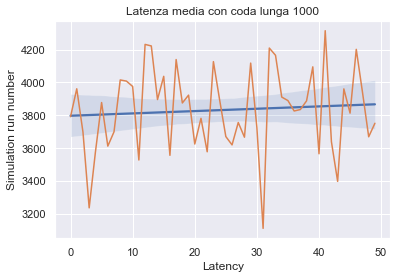

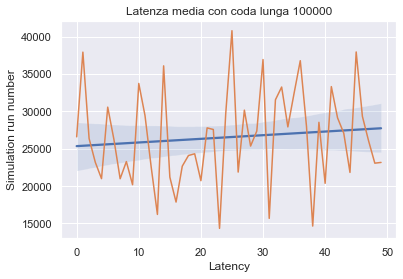

In [1]:
import sys
sys.path.append(r"C:\Users\DULLA\PycharmProjects\Thesis_Data_Analisys\models")
sys.path.append(r"C:\Users\DULLA\PycharmProjects\Thesis_Data_Analisys")
import random
import functools
import seaborn as sns
import simpy
import numpy
import matplotlib.pyplot as plt
import pandas
from models import SimComponents
from SimComponents import PacketGenerator, PacketSink, SwitchPort, PortMonitor
adist = functools.partial(random.expovariate, 0.01)
sdist = functools.partial(random.expovariate, 0.05)  # mean size 100 bytes
samp_dist = functools.partial(random.expovariate, 0.005)
port_rate = 1.5

env = simpy.Environment()  # Create the SimPy environment
# Create the packet generators and sink
ps = PacketSink(env, debug=False, rec_arrivals=True)
pg = PacketGenerator(env, "Greg", adist, sdist)
switch_port = SwitchPort(env, port_rate, qlimit=100000)
# Using a PortMonitor to track queue sizes over time
pm = PortMonitor(env, switch_port, samp_dist)
# Wire packet generators, switch ports, and sinks together
pg.out = switch_port
switch_port.out = ps
# Run it
env.run(until=8000000)
# print("Last 10 waits: " + ", ".join(["{:.3f}".format(x) for x in ps.waits[-10:]]))
# print("Last 10 queue sizes: {}".format(pm.sizes[-1000:]))

fig, axis = plt.subplots()
axis.plot(pm.sizes)
axis.set_title("Line plot for System Occupation")
axis.set_xlabel("time")
axis.set_ylabel("customers in system")
plt.show()
sns.set_theme(style="darkgrid")

# print("Last 10 sink arrival times: " + ", ".join(["{:.3f}".format(x) for x in ps.arrivals[-10:]]))
print("average wait = {:.3f}".format(sum(ps.waits) / len(ps.waits)))
print(
    "received: {}, dropped {}, sent {}".format(switch_port.packets_rec, switch_port.packets_drop, pg.packets_sent))
print("loss rate: {}".format(float(switch_port.packets_drop) / switch_port.packets_rec))
print("average system occupancy: {:.3f}".format(float(sum(pm.sizes)) / len(pm.sizes)))
fig, axis = plt.subplots()
axis.hist(ps.waits, bins=10000, density=True)
axis.set_title("Histogram for Sojourn times")
axis.set_xlabel("number")
axis.set_ylabel("normalized frequency of occurrence")
plt.show()
fig, axis = plt.subplots()
axis.hist(ps.arrivals, bins=100, density=True)
axis.set_title("Histogram for Sink Interarrival times")
axis.set_xlabel("time")
axis.set_ylabel("normalized frequency of occurrence")
plt.show()
i = 0
avgWait = []
del env, ps, pg, pm, switch_port
while i < 50:
    env = simpy.Environment()
    ps = PacketSink(env, debug=False, rec_arrivals=True)
    pg = PacketGenerator(env, "Greg", adist, sdist)
    switch_port = SwitchPort(env, port_rate, qlimit=1000)
    pm = PortMonitor(env, switch_port, samp_dist)
    pg.out = switch_port
    switch_port.out = ps
    env.run(until=800000)
    wait = sum(ps.waits) / len(ps.waits)
    # print("average wait = {:.3f}".format(wait))
    avgWait.append(str(wait))
    del env, ps, pg, pm, switch_port
    i += 1
sns.set()
fig, axes = plt.subplots()
plt.title("Latenza media con coda lunga 1000")
avgWait = numpy.asarray(avgWait, dtype=numpy.single)
df = pandas.DataFrame({"y": avgWait, "x": numpy.asarray(range(len(avgWait)), dtype=numpy.single)})
sns.regplot(x="x", y="y", data=df, scatter=False)
p = sns.lineplot(x="x", y="y", data=df)
p.set(xlabel="Latency", ylabel="Simulation run number")
plt.show()
i = 0
del avgWait, df
# del env, ps, pg, pm, switch_port
avgWait = []
while i < 50:
    env = simpy.Environment()
    ps = PacketSink(env, debug=False, rec_arrivals=True)
    pg = PacketGenerator(env, "Greg", adist, sdist)
    switch_port = SwitchPort(env, port_rate, qlimit=100000)
    pm = PortMonitor(env, switch_port, samp_dist)
    pg.out = switch_port
    switch_port.out = ps
    env.run(until=800000)
    wait = sum(ps.waits) / len(ps.waits)
    # print("average wait = {:.3f}".format(wait))
    avgWait.append(str(wait))
    del env, ps, pg, pm, switch_port
    i += 1
sns.set()
fig, axes = plt.subplots()
avgWait = numpy.asarray(avgWait, dtype=numpy.single)
plt.title("Latenza media con coda lunga 100000")
df = pandas.DataFrame({"y": avgWait, "x": numpy.asarray(range(len(avgWait)), dtype=numpy.single)})
sns.regplot(x="x", y="y", data=df, scatter=False)
p = sns.lineplot(x="x", y="y", data=df)
p.set(xlabel="Latency", ylabel="Simulation run number")
plt.show()


Da questi grafici vediamo come il traffico sia da trattare in modo diverso rispetto alla classica elaborazione statistica
dei segnali. Tutto questo nasce dal fatto che ho bisogno di implementare un controllo della rete. I benefici dell'uso di
algoritmi di controllo SDN unito alle tecniche di controllo SDN per la disseminazione dei risultati e dei comandi, 
verranno esposti nell'ultimo capitolo che presenta le applicazioni e i risultati delle simulazioni delle varie applicazioni.